In [ ]:
import sys
sys.path.append('/workspace/bayes3d')
sys.path.append('/workspace/nvdiffrast')
sys.path.append('/workspace/nvdiffrast/samples/torch')  # for `import util`
# sys.path.append('/workspace/nvdiffrast/nvdiffrast/torch')  # for 'nvdiffrast.torch'

In [ ]:
# Setup within Docker environment
# !pip install -e /workspace/bayes3d
## !pip install -e /workspace/nvdiffrast/

In [3]:
import argparse
import os
import pathlib
import sys
import numpy as np
import jax
import jax.numpy as jnp
import torch
import imageio
import util
import bayes3d as b
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

I0000 00:00:1696393230.968485    5093 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [4]:
b.t3d # sanity check import

<module 'bayes3d.transforms_3d' from '/workspace/bayes3d/bayes3d/transforms_3d.py'>

In [5]:
import nvdiffrast.torch as dr

In [6]:
max_iter           = 10000
repeats            = 1
log_interval       = 10
display_interval   = None
display_res        = 512
lr_base            = 1e-3
lr_falloff         = 1.0
nr_base            = 1.0
nr_falloff         = 1e-4
grad_phase_start   = 0.5
resolution         = 256
out_dir            = None
log_fn             = None
mp4save_interval   = None
mp4save_fn         = None
use_opengl         = False

In [7]:
glctx = dr.RasterizeGLContext() #if use_opengl else dr.RasterizeCudaContext()
mvp = torch.tensor(np.matmul(util.projection(x=0.4), util.translate(0, 0, -3.5)).astype(np.float32), device='cuda')

In [8]:

#----------------------------------------------------------------------------
# Quaternion math.
#----------------------------------------------------------------------------

# Unit quaternion.
def q_unit():
    return np.asarray([1, 0, 0, 0], np.float32)

# Get a random normalized quaternion.
def q_rnd():
    u, v, w = np.random.uniform(0.0, 1.0, size=[3])
    v *= 2.0 * np.pi
    w *= 2.0 * np.pi
    return np.asarray([(1.0-u)**0.5 * np.sin(v), (1.0-u)**0.5 * np.cos(v), u**0.5 * np.sin(w), u**0.5 * np.cos(w)], np.float32)

# Get a random quaternion from the octahedral symmetric group S_4.
_r2 = 0.5**0.5
_q_S4 = [[ 1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [ 0.0, 0.0, 1.0, 0.0], [ 0.0, 0.0, 0.0, 1.0],
         [-0.5, 0.5, 0.5, 0.5], [-0.5,-0.5,-0.5, 0.5], [ 0.5,-0.5, 0.5, 0.5], [ 0.5, 0.5,-0.5, 0.5],
         [ 0.5, 0.5, 0.5, 0.5], [-0.5, 0.5,-0.5, 0.5], [ 0.5,-0.5,-0.5, 0.5], [-0.5,-0.5, 0.5, 0.5],
         [ _r2,-_r2, 0.0, 0.0], [ _r2, _r2, 0.0, 0.0], [ 0.0, 0.0, _r2, _r2], [ 0.0, 0.0,-_r2, _r2],
         [ 0.0, _r2, _r2, 0.0], [ _r2, 0.0, 0.0,-_r2], [ _r2, 0.0, 0.0, _r2], [ 0.0,-_r2, _r2, 0.0],
         [ _r2, 0.0, _r2, 0.0], [ 0.0, _r2, 0.0, _r2], [ _r2, 0.0,-_r2, 0.0], [ 0.0,-_r2, 0.0, _r2]]
def q_rnd_S4():
    return np.asarray(_q_S4[np.random.randint(24)], np.float32)

# Quaternion slerp.
def q_slerp(p, q, t):
    d = np.dot(p, q)
    if d < 0.0:
        q = -q
        d = -d
    if d > 0.999:
        a = p + t * (q-p)
        return a / np.linalg.norm(a)
    t0 = np.arccos(d)
    tt = t0 * t
    st = np.sin(tt)
    st0 = np.sin(t0)
    s1 = st / st0
    s0 = np.cos(tt) - d*s1
    return s0*p + s1*q

# Quaterion scale (slerp vs. identity quaternion).
def q_scale(q, scl):
    return q_slerp(q_unit(), q, scl)

# Quaternion product.
def q_mul(p, q):
    s1, V1 = p[0], p[1:]
    s2, V2 = q[0], q[1:]
    s = s1*s2 - np.dot(V1, V2)
    V = s1*V2 + s2*V1 + np.cross(V1, V2)
    return np.asarray([s, V[0], V[1], V[2]], np.float32)

# Angular difference between two quaternions in degrees.
def q_angle_deg(p, q):
    p = p.detach().cpu().numpy()
    q = q.detach().cpu().numpy()
    d = np.abs(np.dot(p, q))
    d = min(d, 1.0)
    return np.degrees(2.0 * np.arccos(d))

# Quaternion product
def q_mul_torch(p, q):
    a = p[0]*q[0] - p[1]*q[1] - p[2]*q[2] - p[3]*q[3]
    b = p[0]*q[1] + p[1]*q[0] + p[2]*q[3] - p[3]*q[2]
    c = p[0]*q[2] + p[2]*q[0] + p[3]*q[1] - p[1]*q[3]
    d = p[0]*q[3] + p[3]*q[0] + p[1]*q[2] - p[2]*q[1]
    return torch.stack([a, b, c, d])

# Convert quaternion to 4x4 rotation matrix.
def q_to_mtx(q):
    r0 = torch.stack([1.0-2.0*q[1]**2 - 2.0*q[2]**2, 2.0*q[0]*q[1] - 2.0*q[2]*q[3], 2.0*q[0]*q[2] + 2.0*q[1]*q[3]])
    r1 = torch.stack([2.0*q[0]*q[1] + 2.0*q[2]*q[3], 1.0 - 2.0*q[0]**2 - 2.0*q[2]**2, 2.0*q[1]*q[2] - 2.0*q[0]*q[3]])
    r2 = torch.stack([2.0*q[0]*q[2] - 2.0*q[1]*q[3], 2.0*q[1]*q[2] + 2.0*q[0]*q[3], 1.0 - 2.0*q[0]**2 - 2.0*q[1]**2])
    rr = torch.transpose(torch.stack([r0, r1, r2]), 1, 0)
    rr = torch.cat([rr, torch.tensor([[0], [0], [0]], dtype=torch.float32).cuda()], dim=1) # Pad right column.
    rr = torch.cat([rr, torch.tensor([[0, 0, 0, 1]], dtype=torch.float32).cuda()], dim=0)  # Pad bottom row.
    return rr

# Transform vertex positions to clip space
def transform_pos(mtx, pos):
    t_mtx = torch.from_numpy(mtx).cuda() if isinstance(mtx, np.ndarray) else mtx
    # (x,y,z) -> (x,y,z,1)
    posw = torch.cat([pos, torch.ones([pos.shape[0], 1]).cuda()], axis=1)
    return torch.matmul(posw, t_mtx.t())[None, ...]

def render(glctx, mtx, pos, pos_idx, col, col_idx, resolution: int):
    # Setup TF graph for reference.
    depth_ = pos[..., 2:3]
    depth = torch.tensor([[[(z_val/1)] for z_val in depth_.squeeze()]], dtype=torch.float32).cuda()
    pos_clip    = transform_pos(mtx, pos)
    rast_out, _ = dr.rasterize(glctx, pos_clip, pos_idx, resolution=[resolution, resolution])
    color   , _ = dr.interpolate(depth, rast_out, pos_idx)
    # color       = dr.antialias(color, rast_out, pos_clip, pos_idx)
    return color
    # return rast_out[:,:,:,2:3]
    

    
################  Added  ######################
from scipy.spatial.transform import Rotation as R

# Convert quaternion and position vector to 4x4 rotation matrix.
def q_v_to_mtx(q, v):
    r0 = torch.stack([1.0-2.0*q[1]**2 - 2.0*q[2]**2, 2.0*q[0]*q[1] - 2.0*q[2]*q[3], 2.0*q[0]*q[2] + 2.0*q[1]*q[3]])
    r1 = torch.stack([2.0*q[0]*q[1] + 2.0*q[2]*q[3], 1.0 - 2.0*q[0]**2 - 2.0*q[2]**2, 2.0*q[1]*q[2] - 2.0*q[0]*q[3]])
    r2 = torch.stack([2.0*q[0]*q[2] - 2.0*q[1]*q[3], 2.0*q[1]*q[2] + 2.0*q[0]*q[3], 1.0 - 2.0*q[0]**2 - 2.0*q[1]**2])
    rr = torch.transpose(torch.stack([r0, r1, r2]), 1, 0)
    rr = torch.cat([rr, torch.reshape(v, (3,1))], dim=1) 
    rr = torch.cat([rr, torch.tensor([[0, 0, 0, 1]], dtype=torch.float32).cuda()], dim=0)  # Pad bottom row.
    return rr

# Convert quaternion and position vector to 4x4 rotation matrix.
def q_v_to_mtx_batch(qs, vs):
    return torch.stack([q_v_to_mtx(q, v) for q,v in zip(qs, vs)])


# Get a random position near the origin.
def v_rnd():
    x, y, z = np.random.uniform(-0.005, 0.005, size=[3])
    return np.asarray([x, y, z], np.float32)

# Multiple renders
def render_multiple(glctx, poses, vtx_pos, pos_idx, vtx_col, col_idx, resolution):
    ret = torch.cat([render(glctx, pose, vtx_pos, 
                             pos_idx, vtx_col, 
                             col_idx, resolution) for pose in poses], axis=0)
    return ret

In [9]:
datadir = "/workspace/nvdiffrast/samples/data/"
with np.load(f'{datadir}/cube_p.npz') as f:
    pos_idx, pos, col_idx, col = f.values()
print("Mesh has %d triangles and %d vertices." % (pos_idx.shape[0], pos.shape[0]))

# Some input geometry contains vertex positions in (N, 4) (with v[:,3]==1).  Drop
# the last column in that case.
if pos.shape[1] == 4: pos = pos[:, 0:3]

# Create position/triangle index tensors
pos_idx = torch.from_numpy(pos_idx.astype(np.int32)).cuda()
vtx_pos = torch.from_numpy(pos.astype(np.float32)).cuda()
col_idx = torch.from_numpy(col_idx.astype(np.int32)).cuda()
vtx_col = torch.from_numpy(col.astype(np.float32)).cuda()

# model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
# idx = 14
# mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
# m = b.utils.load_mesh(mesh_path)
# m = b.utils.scale_mesh(m, 1.0/100.0)

# vtx_pos = torch.from_numpy(m.vertices.astype(np.float32)).cuda()
# pos_idx = torch.from_numpy(m.faces.astype(np.int32)).cuda()
# col_idx = torch.from_numpy(np.zeros((vtx_pos.shape[0],3)).astype(np.int32)).cuda()
# vtx_col = torch.from_numpy(np.ones((1,3)).astype(np.float32)).cuda()
# print("Mesh has %d triangles and %d vertices." % (pos_idx.shape[0], pos.shape[0]))
# print(pos_idx.shape, vtx_pos.shape, col_idx.shape, vtx_col.shape)
# print(vtx_col)

Mesh has 12 triangles and 24 vertices.


#### Setup visualization for gradients and particles

In [10]:
UNIT_VECTOR = np.array([0,0,1])  # unit for viz

In [11]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

def plot_polar_angles_on_frame(thetas, phis, curr_ax):
    ax = curr_ax
    scaling = 0.96
    for theta in thetas:
        for phi in phis:
            x = np.cos(phi)*np.cos(theta)
            y = np.cos(phi)*np.sin(theta)
            z = np.sin(phi)
            ax.scatter(x * scaling, y, z, s=5**2, color="red", alpha=1)
            u, v, w = 1,0,0
#             ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True, alpha=0.8)
# _, ax = generate_sphere_plot()
# phis = np.arange(0, np.pi, np.pi/10)
# thetas = [0]
# plot_polar_angles_on_frame(thetas, phis, ax)

def plot_cartesian_point_on_frame(point, curr_ax, color="red", alpha=1):
    ax = curr_ax
    x, y, z = point
    ax.scatter(x, y, z, s=5**2, color=color, alpha=alpha)
    
def plot_rot_and_pos(rot_pt, pos_pt, ax_r, ax_p, color="red", alpha=1, label=None, rot_title=None, pos_title=None):
    """Given points on the spherical coord and the cartesian coord,
    Plot on the corresponding rotation and position axes"""
    rx, ry, rz = rot_pt[..., 0], rot_pt[..., 1], rot_pt[..., 2]
    px, py, pz = pos_pt[..., 0], pos_pt[..., 1], pos_pt[..., 2]
    ax_r.scatter(rx, ry, rz, s=5**2, color=color, alpha=alpha, label=label)
    ax_p.scatter(px, py, pz, s=5**2, color=color, alpha=alpha, label=label)
    
    if label is not None:
        ax_r.legend()
#         ax_p.legend(loc="upper left")
    if rot_title is not None:
        ax_r.set_title(rot_title)
    if pos_title is not None:
        ax_p.set_title(pos_title)

# _, ax = generate_sphere_plot(show_unit=True)

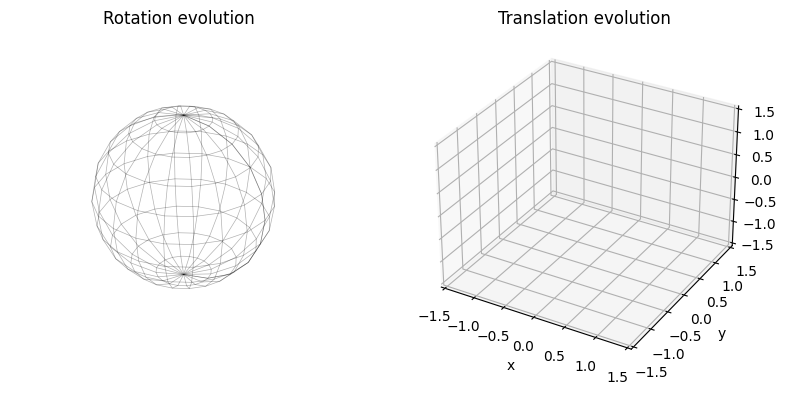

In [12]:
def generate_sphere_plot(show_unit=False, fig_ax=None):
    if fig_ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    else:
        fig, ax = fig_ax
        
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    u, v = np.mgrid[0:2*np.pi:21j, 0:np.pi:11j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.set_axis_off()
    ax.axes.set_xlim3d(-1.05, 1.05) 
    ax.axes.set_ylim3d(-1.05, 1.05) 
    ax.axes.set_zlim3d(-1.05, 1.05) 
    ax.set_aspect("equal")
    ax.plot_wireframe(x, y, z, color=(0.0, 0.0, 0.0, 0.3), linewidths=0.5)

    ax.axes.set_xlabel("x")
    ax.axes.set_ylabel("y")
    ax.axes.set_zlabel("z")

    if show_unit:
        quat_unit = q_to_mtx(torch.tensor([1,0,0,0], device="cuda", dtype=torch.float64)).cpu()[:3, :3] @ torch.tensor(UNIT_VECTOR, dtype=torch.float64) 
        ax.scatter(quat_unit[0], quat_unit[1], quat_unit[2], color="green", alpha=1)
    return fig, ax
# _, ax = generate_sphere_plot(show_unit=True)

def generate_cartesian_plot(show_unit=False, fig_ax=None):
    if fig_ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    else:
        fig, ax = fig_ax
#     ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#     ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#     ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
    ax.axes.set_xlim3d(-1.5, 1.5) 
    ax.axes.set_ylim3d(-1.5, 1.5) 
    ax.axes.set_zlim3d(-1.5, 1.5) 
    
    ax.axes.set_xlabel("x")
    ax.axes.set_ylabel("y")
    ax.axes.set_zlabel("z")
    
    if show_unit:
        ax.scatter(0.0, 0.0, 0.0, s=5**2, color="green", alpha=1)
    return fig, ax
# _, ax = generate_cartesian_plot(True)

def generate_rotation_translation_plot(show_unit=False):
    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize=plt.figaspect(0.5))

    # set up the axes for the first plot
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    # Generate the subplots
    _, _ = generate_sphere_plot(show_unit, (fig, ax1))
    _, _ = generate_cartesian_plot(show_unit, (fig, ax2))

    # Label with title
    ax1.set_title("Rotation evolution")
    ax2.set_title("Translation evolution")
    
    return fig, (ax1, ax2)


_, (ax_r, ax_t) = generate_rotation_translation_plot(False)


In [20]:
def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


## Single pose hypothesis optimization

In [21]:
set_seed(0)

Random seed set as 0


#### Define GT

In [22]:
# GT) Rotation, Position poses
pose_rot_target = torch.tensor(q_rnd(), device='cuda')
pose_pos_target = torch.tensor(v_rnd(), device='cuda')
pose_target = q_v_to_mtx(pose_rot_target, pose_pos_target)
print("TARGET POSE=", pose_target)

# Initial GT render
rast_target = render(glctx, torch.matmul(mvp, pose_target), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
img_target  = rast_target[0].detach().cpu().numpy()

TARGET POSE= tensor([[ 5.6007e-01,  7.1866e-01,  4.1213e-01,  4.4883e-04],
        [-3.3639e-01, -2.5733e-01,  9.0588e-01, -7.6345e-04],
        [ 7.5707e-01, -6.4599e-01,  9.7627e-02,  1.4589e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')


#### Define hypothesis / setup GD

tensor([-0.6778, -0.0558, -0.4217, -0.5997], device='cuda:0',
       requires_grad=True) tensor([0.0880, 0.1776, 0.1942], device='cuda:0', requires_grad=True)
torch.Size([4, 4])
target pose=tensor([[ 5.6007e-01,  7.1866e-01,  4.1213e-01,  4.4883e-04],
        [-3.3639e-01, -2.5733e-01,  9.0588e-01, -7.6345e-04],
        [ 7.5707e-01, -6.4599e-01,  9.7627e-02,  1.4589e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0'),
current pose=tensor([[ 0.6380,  0.5815,  0.5048,  0.0880],
        [-0.4302, -0.2745,  0.8600,  0.1776],
        [ 0.6386, -0.7659,  0.0750,  0.1942],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0',
       grad_fn=<CatBackward0>)
torch.Size([1, 256, 256, 1]) (256, 256, 1)


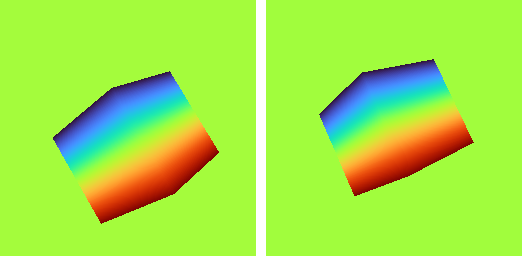

In [23]:
# Opt) Rotation, Position poses
pose_rot_init   = pose_rot_target.cpu().numpy() + 0.1 #+ 1.5
pose_pos_init   = pose_pos_target.cpu().numpy() + np.random.rand(3,)/5

pose_rot_opt    = torch.tensor(pose_rot_init / np.sum(pose_rot_init**2)**0.5, dtype=torch.float32, device='cuda', requires_grad=True)
pose_pos_opt    = torch.tensor(pose_pos_init, dtype=torch.float32, device='cuda', requires_grad=True)
print(pose_rot_opt, pose_pos_opt)

pose_opt = q_v_to_mtx(pose_rot_opt, pose_pos_opt)
print(pose_opt.shape)

# initialize loss 
loss_best   = np.inf

# Visualize initial state
print(f"target pose={pose_target},\ncurrent pose={pose_opt}")

# Initial opt render
rast_opt = render(glctx, torch.matmul(mvp, pose_opt), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
img_opt  = rast_opt[0].detach().cpu().numpy()
print(rast_opt.shape, img_opt.shape)

b.hstack_images([
    b.get_depth_image(img_opt[:,:,0]* 255.0) ,
    b.get_depth_image(img_target[:,:,0]* 255.0) ,
])

#### Run GD

100%|████████████████████████████████████████| 120/120 [01:29<00:00,  1.35it/s]


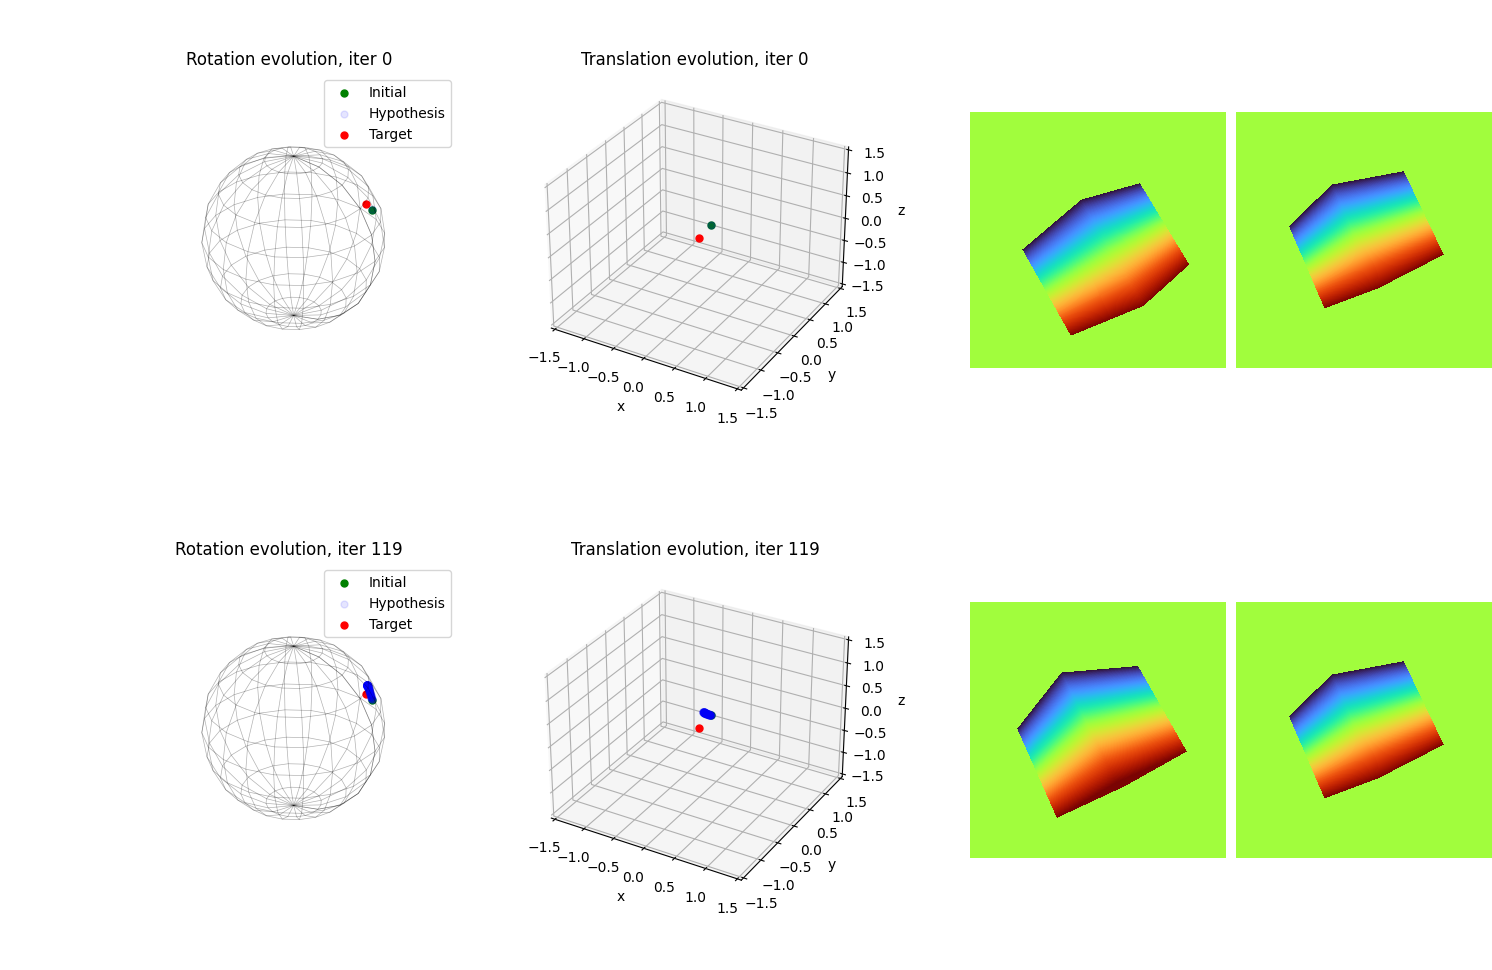

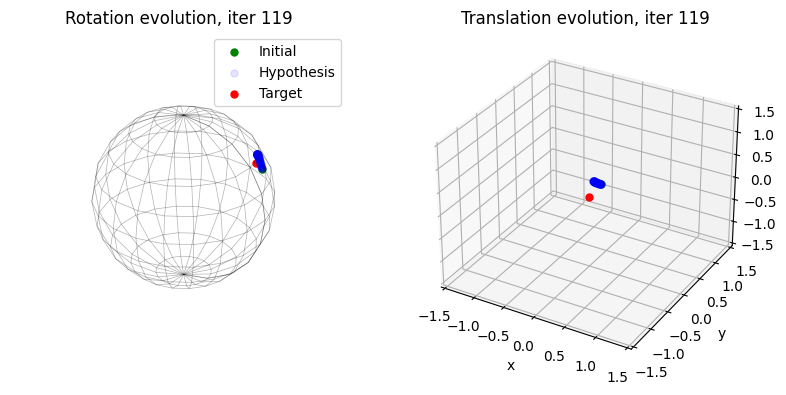

In [24]:
def descend_gradient(pose_rot_opt, pose_pos_opt, pose_target, rast_opt, rast_target, it=20, verbose=False, plot=False):
    OPTIM_GIF_IMGS = []
    loss_best = np.inf
    optimizer = torch.optim.Adam([pose_rot_opt, pose_pos_opt], betas=(0.9, 0.999), lr=lr_base)
    
    if plot: 
        fig, (ax_r, ax_t) = generate_rotation_translation_plot(False)
        plot_rot_and_pos(pose_opt.detach().cpu()[:3, :3] @ UNIT_VECTOR, 
                 pose_opt.detach().cpu()[:3, -1], 
                 ax_r, ax_t, 
                 color="green", alpha=1, label="Initial")
        plot_rot_and_pos(pose_opt.detach().cpu()[:3, :3] @ UNIT_VECTOR, 
                         pose_opt.detach().cpu()[:3, -1], 
                         ax_r, ax_t, 
                         color="blue", alpha=0.1, label="Hypothesis")
        plot_rot_and_pos(pose_target.detach().cpu()[:3, :3] @ UNIT_VECTOR, 
                         pose_target.detach().cpu()[:3, -1], 
                         ax_r, ax_t, 
                         color="red", alpha=1, label="Target")

        
    for i in tqdm(range(it)):
        noise = q_unit()
        pose_rot_total_opt = q_mul_torch(pose_rot_opt, noise)
        mtx_total_opt  = torch.matmul(mvp, q_v_to_mtx(pose_rot_total_opt, pose_pos_opt))
        color_opt      = render(glctx, mtx_total_opt, vtx_pos, pos_idx, vtx_col, col_idx, resolution)

        diff = (rast_opt - rast_target)**2 # L2 norm.
        diff = torch.tanh(5.0 * torch.max(diff, dim=-1)[0])
        loss = torch.mean(diff)
        loss_val = float(loss)

        if (loss_val < loss_best) and (loss_val > 0.0):
            loss_best = loss_val
        if (loss_val/loss_best > 1.2):
            break
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            pose_rot_opt /= torch.sum(pose_rot_opt**2)**0.5

        rast_opt = render(glctx, torch.matmul(mvp, q_v_to_mtx(pose_rot_opt, pose_pos_opt)), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
        img_opt  = rast_opt[0].detach().cpu().numpy()
    
    
        if verbose:
            print(f"loss={loss}, rot={pose_rot_total_opt}, pos={pose_pos_opt}")

        curr_render_imgs = b.hstack_images([
                b.get_depth_image(img_opt[:,:,0]* 255.0) ,
                b.get_depth_image(img_target[:,:,0]* 255.0) ,
                ])
        
        if plot:
            pose_opt_curr_val = q_v_to_mtx(pose_rot_opt, pose_pos_opt).detach().cpu() 
            plot_rot_and_pos(pose_opt_curr_val[:3, :3] @ UNIT_VECTOR, 
                         pose_opt_curr_val[:3, -1], 
                         ax_r, ax_t, 
                         color="blue", alpha=0.1,
                         rot_title=f"Rotation evolution, iter {i}", 
                         pos_title=f"Translation evolution, iter {i}")  # current
            curr_PIL = fig2img(fig)
            OPTIM_GIF_IMGS.append(b.hstack_images([curr_PIL, curr_render_imgs]))
        else:
            OPTIM_GIF_IMGS.append(curr_render_imgs)

    return OPTIM_GIF_IMGS

OPTIM_GIF_IMGS = descend_gradient(pose_rot_opt, pose_pos_opt, pose_target, rast_opt, rast_target, it=120, verbose=False, plot=True)
b.viz.make_gif_from_pil_images(OPTIM_GIF_IMGS, "render_imgs.gif")
b.vstack_images([OPTIM_GIF_IMGS[0], OPTIM_GIF_IMGS[-1]])

## Multi pose hypothesis optimization

In [25]:
set_seed(1)

Random seed set as 1


#### Define GT

TARGET POSE= tensor([[ 0.9599,  0.2130,  0.1821, -0.0020],
        [ 0.2118, -0.1259, -0.9692, -0.0035],
        [-0.1835,  0.9689, -0.1660, -0.0041],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')


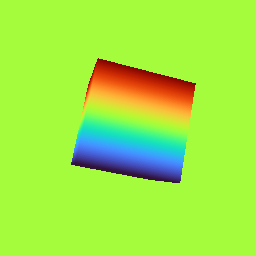

In [26]:
# GT) Rotation, Position poses
pose_rot_target = torch.tensor(q_rnd(), device='cuda')
pose_pos_target = torch.tensor(v_rnd(), device='cuda')
pose_target = q_v_to_mtx(pose_rot_target, pose_pos_target)
print("TARGET POSE=", pose_target)

# Initial GT render
rast_target = render(glctx, torch.matmul(mvp, pose_target), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
img_target  = rast_target[0].detach().cpu().numpy()
b.hstack_images([
    b.get_depth_image(img_target[:,:,0]* 255.0) ,
])

#### Enumerations

In [27]:
####
# Make grid of hypotheses on pose deltas
####

min_x, min_y, min_z, max_x, max_y, max_z = -0.05, -0.05, -0.05, 0.05, 0.05, 0.05
num_x, num_y, num_z = 1,1,1
min_rotation_angle, max_rotation_angle = -jnp.pi/10, jnp.pi/10
sphere_angle_range = jnp.pi/10
fibonacci_sphere_points = 2
num_planar_angle_points = 10


pose_delta_enums_jax = b.utils.enumerations.make_pose_grid_enumeration(min_x,min_y,min_z, min_rotation_angle, 
                        max_x,max_y,max_z, max_rotation_angle,
                        num_x,num_y,num_z, 
                        fibonacci_sphere_points, num_planar_angle_points, 
                        sphere_angle_range=sphere_angle_range)
pose_delta_enums = torch.from_dlpack(jax.dlpack.to_dlpack(pose_delta_enums_jax, True))

#### Define hypotheses / prepare GD

In [28]:
#############
# Define pose hypotheses to run gradient descent on
#############
pose_enums = pose_target @ pose_delta_enums

tensor([-0.6133, -0.1039, -0.4672, -0.6283], device='cuda:0',
       requires_grad=True) tensor([0.0065, 0.0966, 0.2907], device='cuda:0', requires_grad=True)
target pose=tensor([[ 0.9599,  0.2130,  0.1821, -0.0020],
        [ 0.2118, -0.1259, -0.9692, -0.0035],
        [-0.1835,  0.9689, -0.1660, -0.0041],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0'),
current pose=tensor([[ 0.9030,  0.2316, -0.3618, -0.0757],
        [ 0.3891, -0.0840,  0.9174,  0.0375],
        [ 0.1821, -0.9692, -0.1660, -0.0236],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)


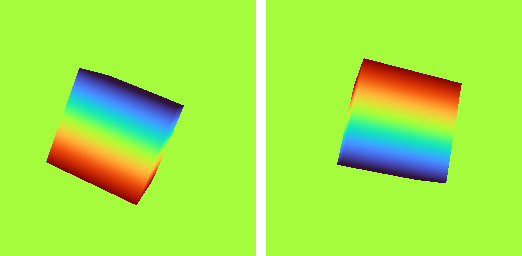

In [29]:
# Opt) Rotation, Position poses
r = R.from_matrix(pose_enums.detach().cpu()[:, :3, :3])
poses_rot_init   = r.as_quat()
poses_pos_init   = pose_enums[:, :3, -1].cpu().numpy() 

poses_rot_opt    = torch.tensor(np.divide(poses_rot_init, (np.sum(poses_rot_init**2, axis=1)**0.5)[:, None]), dtype=torch.float32, device='cuda', requires_grad=True)
poses_pos_opt    = torch.tensor(poses_pos_init, dtype=torch.float32, device='cuda', requires_grad=True)
print(pose_rot_opt, pose_pos_opt)

poses_opt = q_v_to_mtx_batch(poses_rot_opt, poses_pos_opt)

# Initial opt render
rast_opts = render_multiple(glctx, torch.matmul(mvp, poses_opt), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
img_opts  = rast_opts[4].detach().cpu().numpy()

# initialize loss 
loss_best   = np.inf

# Visualize initial state
print(f"target pose={pose_target},\ncurrent pose={poses_opt[4]}")

b.hstack_images([
    b.get_depth_image(img_opts[:,:,0]* 255.0) ,
    b.get_depth_image(img_target[:,:,0]* 255.0) ,
])


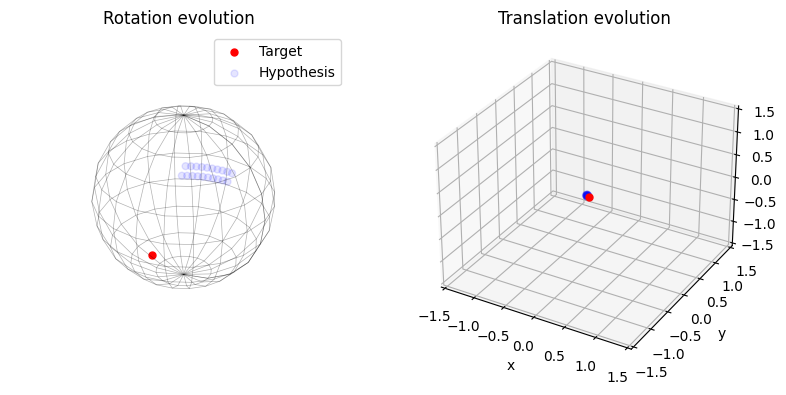

In [30]:
_, (ax_r, ax_t) = generate_rotation_translation_plot(False)
plot_rot_and_pos(pose_target.detach().cpu()[:3, :3] @ UNIT_VECTOR, 
                 pose_target.detach().cpu()[:3, -1], 
                 ax_r, ax_t, 
                 color="red", alpha=1, label="Target")
plot_rot_and_pos(np.einsum('nij,j... -> ni', poses_opt.detach().cpu()[:, :3, :3], UNIT_VECTOR), 
                 poses_opt.detach().cpu()[:, :3, -1], 
                 ax_r, ax_t, 
                 color="blue", alpha=0.1, label="Hypothesis")

#### Run GD

  0%|                                                   | 0/30 [00:00<?, ?it/s]


NameError: name 'PLOT_IMGS' is not defined

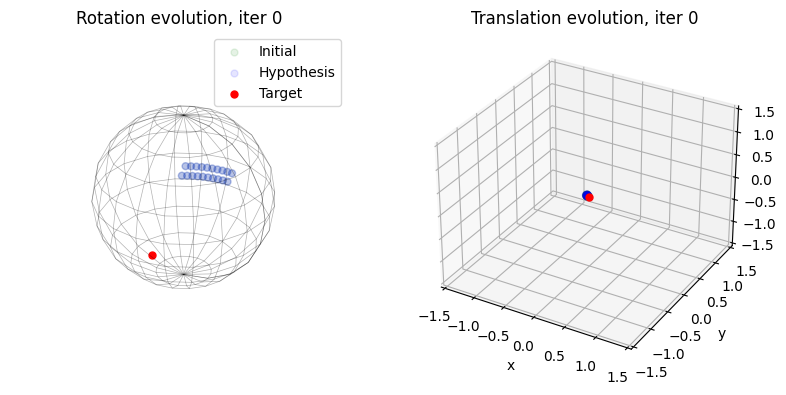

In [31]:
def descend_gradient_multi(pose_rot_opt, pose_pos_opt, pose_target, rast_opts, rast_target, it=20, verbose=False, plot=False):
    OPTIM_GIF_IMGS = []
    loss_best = np.inf
    optimizer = torch.optim.Adam([pose_rot_opt, pose_pos_opt], betas=(0.9, 0.999), lr=2e-7)
    img_target = rast_target[0].detach().cpu().numpy()
    img_target_viz = b.get_depth_image(img_target[:,:,0]* 255.0)
    
    if plot: 
        fig, (ax_r, ax_t) = generate_rotation_translation_plot()
        
        poses_opt = q_v_to_mtx_batch(poses_rot_opt, poses_pos_opt)

        plot_rot_and_pos(np.einsum('nij,j... -> ni', poses_opt.detach().cpu()[:, :3, :3], UNIT_VECTOR), 
                         poses_opt.detach().cpu()[:, :3, -1], 
                         ax_r, ax_t, 
                         color="green", alpha=0.1, label="Initial")
        plot_rot_and_pos(np.einsum('nij,j... -> ni', poses_opt.detach().cpu()[:, :3, :3], UNIT_VECTOR),
                         poses_opt.detach().cpu()[:, :3, -1], 
                         ax_r, ax_t, 
                         color="blue", alpha=0.1, label="Hypothesis")
        plot_rot_and_pos(pose_target.detach().cpu()[:3, :3] @ UNIT_VECTOR, 
                         pose_target.detach().cpu()[:3, -1], 
                         ax_r, ax_t, 
                         color="red", alpha=1, label="Target")

    
    # TODO better convergence condition
    for i in tqdm(range(it)):
    #     noise = q_unit()
        poses_rot_total_opt = poses_rot_opt #q_mul_torch(pose_rot_opt, noise)
        mtx_total_opt  = torch.matmul(mvp, q_v_to_mtx_batch(poses_rot_total_opt, poses_pos_opt))
        color_opts = render_multiple(glctx, mtx_total_opt, vtx_pos, pos_idx, vtx_col, col_idx, resolution)

        diff = (rast_opts - rast_target)**2 # L2 norm.
        diff = torch.tanh(5.0 * torch.max(diff, dim=-1)[0])
        loss = torch.mean(diff)
        loss_val = float(loss)

        if (loss_val < loss_best) and (loss_val > 0.0):
            loss_best = loss_val

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #     with torch.no_grad():
    #         pose_rot_opt /= torch.sum(poses_rot_opt**2, axis=1)**0.5

        rast_opts = render_multiple(glctx, torch.matmul(mvp, q_v_to_mtx_batch(poses_rot_opt, poses_pos_opt)), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
        img_opts  = rast_opts.detach().cpu().numpy()
    
        if verbose:
            print(f"loss={loss}, pos[0]={pose_pos_opt[0]}")

        curr_render_imgs = b.hvstack_images([b.get_depth_image(img_opts[i][:,:,0]* 255.0) for i in range(len(rast_opts))], 
                                       fibonacci_sphere_points*num_x,
                                       num_planar_angle_points*num_y*num_z,
                                       border=10)
        curr_render_imgs = b.vstack_images([img_target_viz, b.scale_image(curr_render_imgs, 0.3)])

        if plot:
            poses_opt_curr_val = q_v_to_mtx_batch(poses_rot_opt, poses_pos_opt).detach().cpu() 
            plot_rot_and_pos(np.einsum('nij,j... -> ni', poses_opt_curr_val[:, :3, :3], UNIT_VECTOR), 
                         poses_opt_curr_val[:, :3, -1], 
                         ax_r, ax_t, 
                         color="blue", alpha=0.1,
                         rot_title=f"Rotation evolution, iter {i}", 
                         pos_title=f"Translation evolution, iter {i}")  # current
            curr_fig = fig2img(fig)
            OPTIM_GIF_IMGS.append(b.hstack_images([curr_fig, curr_render_imgs]))
        else:
            OPTIM_GIF_IMGS.append(curr_render_imgs)

    return OPTIM_GIF_IMGS

OPTIM_GIF_IMGS = descend_gradient_multi(poses_rot_opt, poses_pos_opt, pose_target, 
                                        rast_opts, rast_target, 
                                        it=30, verbose=False, plot=True)
b.viz.make_gif_from_pil_images(OPTIM_GIF_IMGS, "render_imgs_multi.gif")
b.vstack_images([OPTIM_GIF_IMGS[0], OPTIM_GIF_IMGS[-1]])